# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
In this project, my goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

I will do the follow steps to reach the goal:
1. Camrea calibration
2. Distortion correction
3. Use the S channel in HLS, gradient magnitude to create a thresholded binary image
4. Apply a perspective transform to rectify binary image
5. Detect lane pixels and fit to find the lane boundary
6. Determine the curvature of the lane
7. Warp the detected lane boundaries back onto the original image
8. Output visual display

### Import

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print('Import finished.')

Import finished.


### Camera Calibration

Camera Calibration matrix finished.


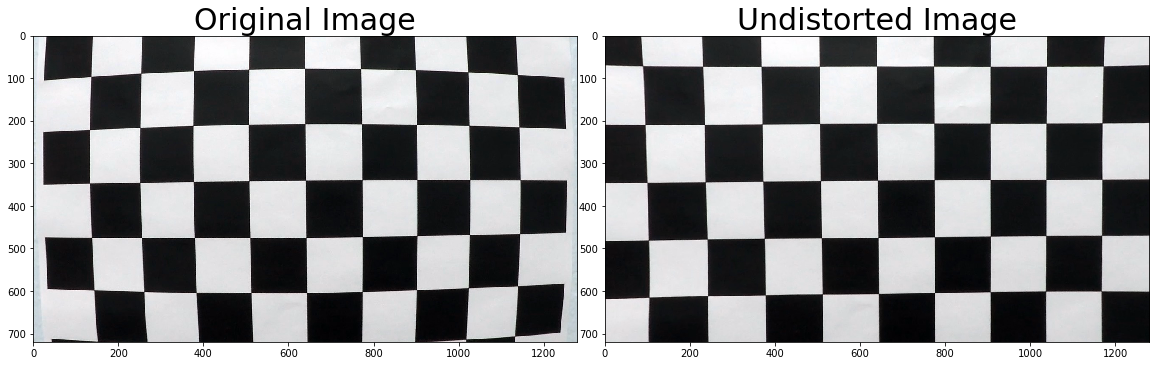

In [91]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)
# cv2.destroyAllWindows()

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undist.jpg', dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("wide_dist_pickle.p", "wb"))

print("Camera Calibration matrix finished.")

### Distortion correction

In [2]:
# undistort the image
def distortion_image(img, mtx, dist):
    """
    :param img: the image which need undistort
    :param mtx: mtx from camera calibration
    :param dist: dist from camera calibration
    :return: undistort image
    """
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    return dst_img

Text(0.5, 1.0, 'Undistorted Image')

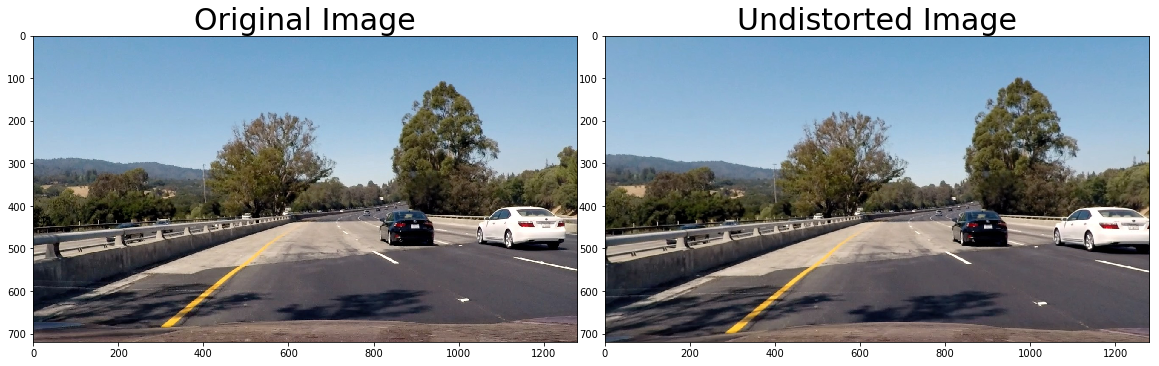

In [3]:
# load mtx and dist from wide_dist_pickle.p
with open('wide_dist_pickle.p', 'rb') as f:
    data = pickle.load(f)
mtx = data['mtx']
dist = data['dist']

# read an example image to do the undistortion
exampleImg = cv2.imread('./test_images/test4.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)

# undistortion
exampleImg_undistort = distortion_image(exampleImg, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)


### Get binary image

#### Unwarp the image

In [4]:
# unwarp function
def unwarp(img):
    """
    :param img: the image which need warp perspective
    :return warped: the image after warp perspective
    :return M: the transform matrix
    :return Minv: the inverse of M
    """
    img_size = (img.shape[1], img.shape[0])
    offset = 150
    # source points of quadrilateral
    src = np.float32([[180, 700], [1100, 700], [574, 460], [706, 460]])
    # destination points of quadrilateral
    dst = np.float32([[offset, img_size[1]], [img_size[0] - offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0]])
    # the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # the inverse of M
    Minv = cv2.getPerspectiveTransform(dst, src)
    # warped image with binary value
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

Text(0.5, 1.0, 'Unwarped Image')

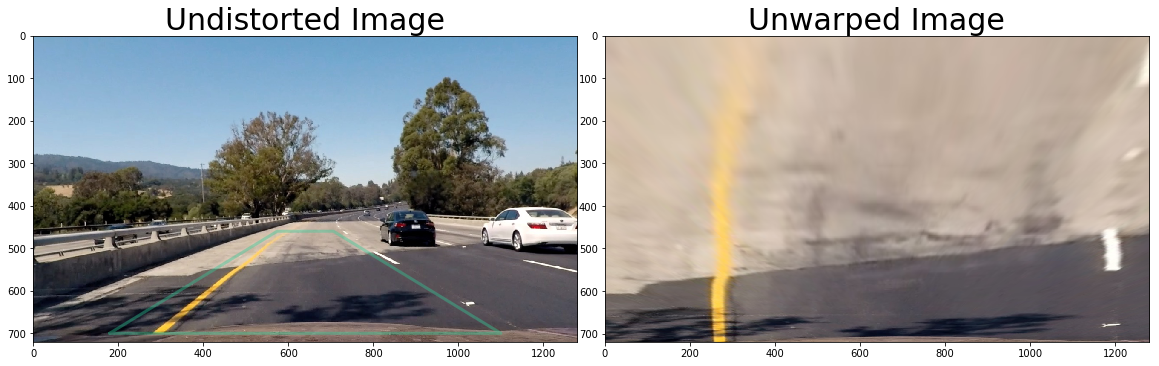

In [5]:
# test the unwarp
exampleImg_unwarp, Mm, Minv = unwarp(exampleImg_undistort)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [180, 1100, 706, 574, 180]
y = [700, 700, 460, 460, 700]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([720,0])
ax1.set_xlim([0,1280])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)

#### Visualize multiple colorspace channels

Text(0.5, 1.0, 'HLS S-Channel')

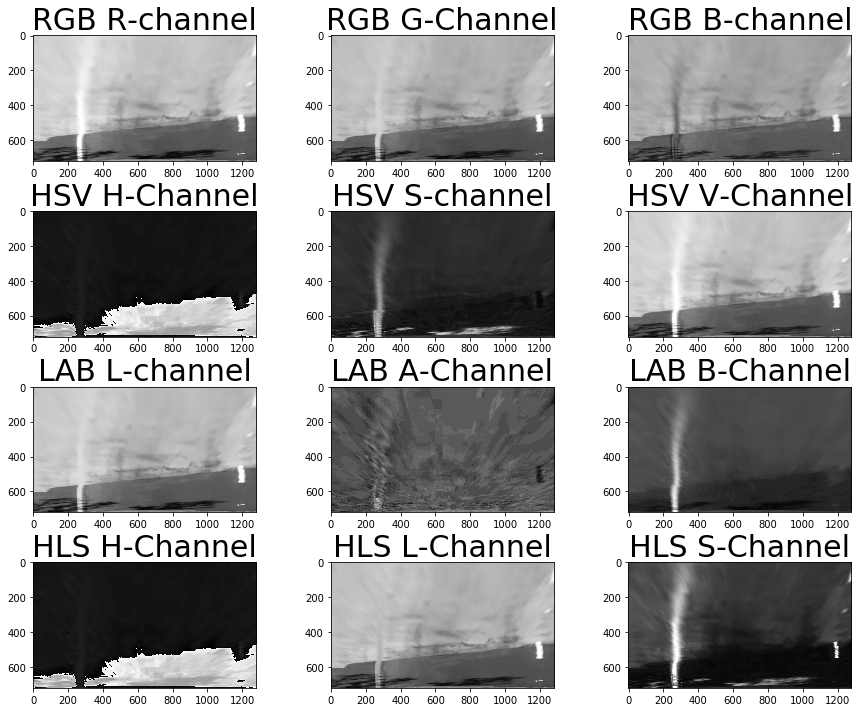

In [6]:
# Visualize multiple color space channels
exampleImg_unwarp_R = exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G = exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B = exampleImg_unwarp[:,:,2]
exampleImg_unwarp_HSV = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HSV)
exampleImg_unwarp_H = exampleImg_unwarp_HSV[:,:,0]
exampleImg_unwarp_S = exampleImg_unwarp_HSV[:,:,1]
exampleImg_unwarp_V = exampleImg_unwarp_HSV[:,:,2]
exampleImg_unwarp_LAB = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2Lab)
exampleImg_unwarp_L = exampleImg_unwarp_LAB[:,:,0]
exampleImg_unwarp_A = exampleImg_unwarp_LAB[:,:,1]
exampleImg_unwarp_B2 = exampleImg_unwarp_LAB[:,:,2]
exampleImg_unwarp_HLS = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HLS)
exampleImg_unwarp_HLS_H = exampleImg_unwarp_HLS[:,:,0]
exampleImg_unwarp_HLS_L = exampleImg_unwarp_HLS[:,:,1]
exampleImg_unwarp_HLS_S = exampleImg_unwarp_HLS[:,:,2]
fig, axs = plt.subplots(4,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .4, wspace=.001)
axs = axs.ravel()
axs[0].imshow(exampleImg_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=30)
axs[1].imshow(exampleImg_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=30)
axs[2].imshow(exampleImg_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=30)
axs[3].imshow(exampleImg_unwarp_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=30)
axs[4].imshow(exampleImg_unwarp_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=30)
axs[5].imshow(exampleImg_unwarp_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=30)
axs[6].imshow(exampleImg_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel', fontsize=30)
axs[7].imshow(exampleImg_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel', fontsize=30)
axs[8].imshow(exampleImg_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel', fontsize=30)
axs[9].imshow(exampleImg_unwarp_HLS_H, cmap='gray')
axs[9].set_title('HLS H-Channel', fontsize=30)
axs[10].imshow(exampleImg_unwarp_HLS_L, cmap='gray')
axs[10].set_title('HLS L-Channel', fontsize=30)
axs[11].imshow(exampleImg_unwarp_HLS_S, cmap='gray')
axs[11].set_title('HLS S-Channel', fontsize=30)

#### Sobel Absolute Threshold

In [7]:
# Sobel absolute threshold function
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(25,255)):
    """
    :param img: the image for the directional gradient calculation
    :param orient: the orient for the calculation, the default value is 'x'
    :param sobel_kernel: the kernel number, the default value is 3
    :param thresh: the threshold for the calculation, the default value is form 0 to 255
    :return grad_binary: the image after directional gradient calculation
    """
    # Convert RGB to gray (because using cv2.imread, here is BGR to gray)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Determine the orient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # absolute the sobel
    abs_sobel = np.absolute(sobel)
    # scale the soble
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # initialize the image
    grad_binary = np.zeros_like(scaled_sobel)
    # set the value to 1 when the scaled_sobel value between the threshold
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary


Text(0.5, 1.0, 'Sobel Magnitude')

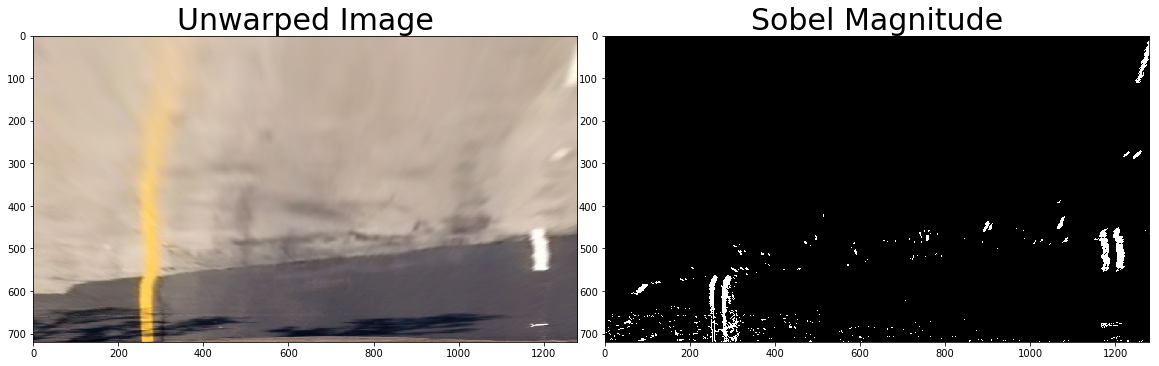

In [8]:
exampleImg_sobelMag = abs_sobel_thresh(exampleImg_unwarp, sobel_kernel = 7, thresh=(20, 120))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(exampleImg_sobelMag, cmap='gray')
ax2.set_title('Sobel Magnitude', fontsize=30)

#### Sobel Gradient Magnitude Threshold

In [9]:
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    """
    :param image: the image for the gradient magnitude calculation
    :param orient: the orient for the calculation, the default value is 'x'
    :param sobel_kernel: the kernel number, the default value is 3
    :param thresh: the threshold for the calculation, the default value is form 0 to 255
    :return mag_binary: the image after gradient magnitude calculation
    """
    # Convert RGB to gray (because using cv2.imread, here is BGR to gray)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # calculate the x and y sobel value
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # implement gradient magnitude
    scaled_sobelxy = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scale_factor = np.max(scaled_sobelxy) / 255
    scaled_sobelxy = (scaled_sobelxy / scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(scaled_sobelxy)
    mag_binary[(scaled_sobelxy >= thresh[0]) & (scaled_sobelxy <= thresh[1])] = 1
    return mag_binary

Text(0.5, 1.0, 'Sobel Gradient Magnitude')

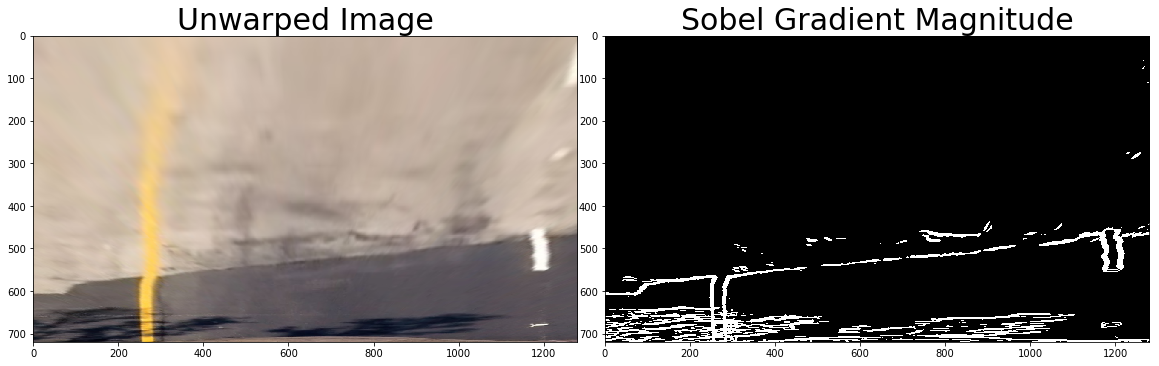

In [10]:
exampleImg_sobelGraMag = mag_thresh(exampleImg_unwarp, sobel_kernel = 7, thresh = (20, 120))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(exampleImg_sobelGraMag, cmap='gray')
ax2.set_title('Sobel Gradient Magnitude', fontsize=30)

#### Combine Sobel Absolute Threshold and Sobel Gradient Magnitude Threshold

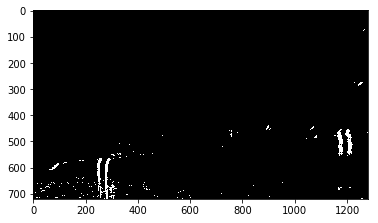

In [11]:
combined1 = np.zeros_like(exampleImg_sobelMag)
combined1[((exampleImg_sobelMag == 1) & (exampleImg_sobelGraMag == 1))] = 1
plt.imshow(combined1, cmap='gray')

#### Sobel Direction Threshold

In [12]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi / 2)):
    """
    :param image: the image for the gradient magnitude calculation
    :param sobel_kernel: the kernel number, the default value is 3
    :param thresh: the threshold for the calculation, the default value is form 0 to pi / 2
    :return dir_binary: the image after gradient magnitude calculation
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_gra = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(gray)
    dir_binary[(dir_gra >= thresh[0]) & (dir_gra <= thresh[1])] = 1
    return dir_binary

Text(0.5, 1.0, 'Sobel Direction Threshold')

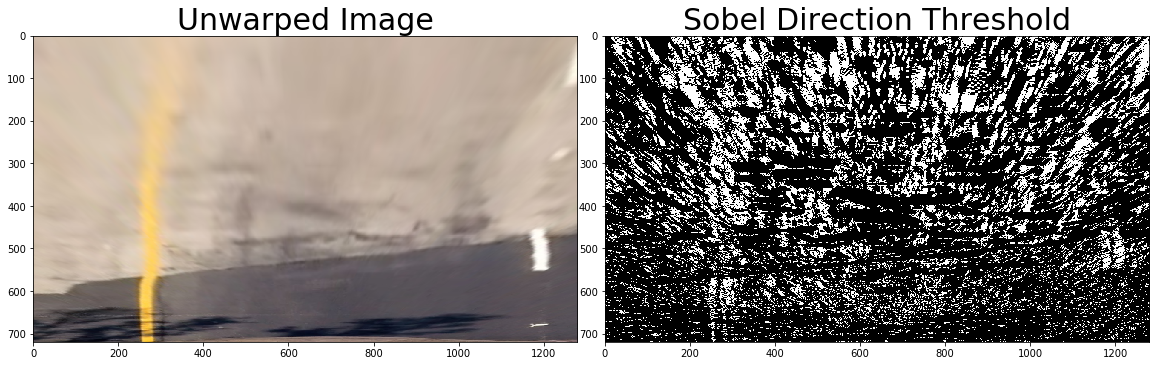

In [13]:
exampleImg_sobelDir = dir_threshold(exampleImg_unwarp, sobel_kernel = 7, thresh = (0.1, 0.6))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(exampleImg_sobelDir, cmap='gray')
ax2.set_title('Sobel Direction Threshold', fontsize=30)

#### Combine Sobel Gradient Magnitude Threshold, Sobel Absolute Threshold and Sobel Direction Threshold

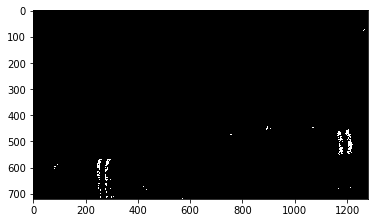

In [14]:
combined2 = np.zeros_like(exampleImg_sobelMag)
combined2[((combined1 == 1) & (exampleImg_sobelDir == 1))] = 1
plt.imshow(combined2, cmap='gray')

#### HLS S-Channel Threshold

In [15]:
def HLS_s_thresh(image, thresh=(0, 255)):
    """
    :param img: the image for the HLS calculation
    :param thresh: the threshold for S-channel, the default value is form 0 to 255
    :return s_binary: the image record S-channel binary value
    """
    # convert RGB to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # choose the S channel form HLS space
    s_channel = hls[:, :, 2]
    # initialize the image
    s_binary = np.zeros_like(s_channel)
    # set the value to 1 when the S-channel value between the threshold
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    return s_binary

Text(0.5, 1.0, 'HLS S-Channel Threshold')

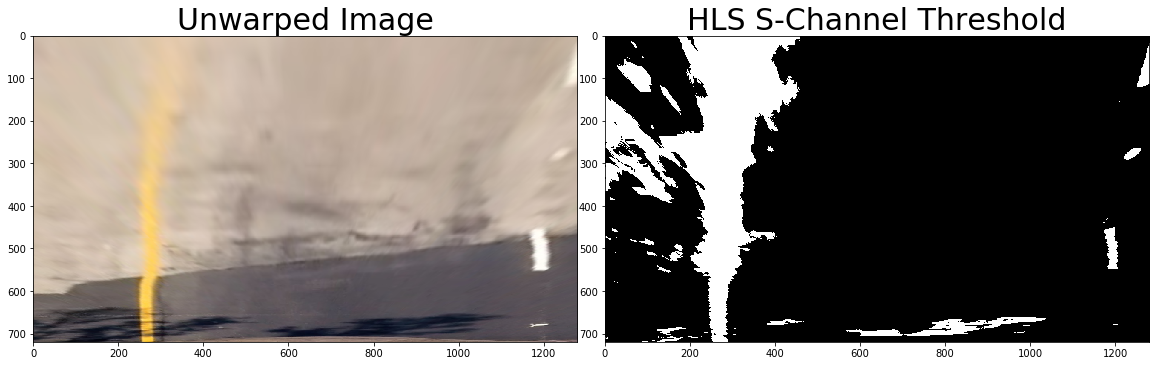

In [16]:
exampleImg_schannel = HLS_s_thresh(exampleImg_unwarp, thresh = (80, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(exampleImg_schannel, cmap='gray')
ax2.set_title('HLS S-Channel Threshold', fontsize=30)

#### RGB R-Channel Threshold

In [17]:
def RGB_r_thresh(image, thresh=(0, 255)):
    """
    :param img: the image for the HLS calculation
    :param thresh: the threshold for R-channel, the default value is form 0 to 255
    :return s_binary: the image record R-channel binary value
    """
    # choose the R-channel form RGB space
    r_channel = image[:, :, 0]
    # initialize the image
    r_binary = np.zeros_like(r_channel)
    # set the value to 1 when the s_channel value between the threshold
    r_binary[(r_channel >= thresh[0]) & (r_channel <= thresh[1])] = 1
    return r_binary

Text(0.5, 1.0, 'RGB R-Channel Threshold')

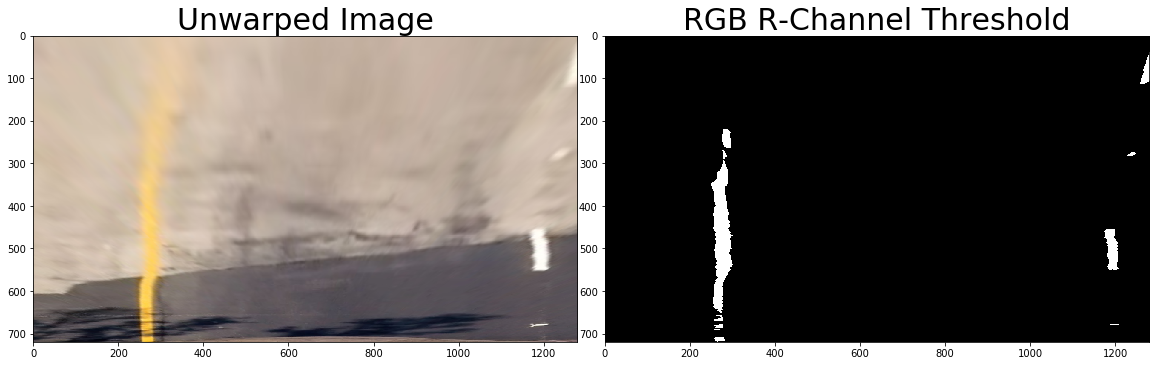

In [18]:
exampleImg_rchannel = RGB_r_thresh(exampleImg_unwarp, thresh = (240, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(exampleImg_rchannel, cmap='gray')
ax2.set_title('RGB R-Channel Threshold', fontsize=30)

#### Combine S-Channel Threshold and R-Channel Threshold

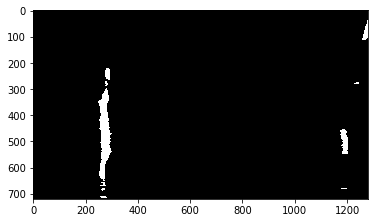

In [19]:
combined3 = np.zeros_like(exampleImg_sobelMag)
combined3[((exampleImg_schannel == 1) & (exampleImg_rchannel == 1))] = 1
plt.imshow(combined3, cmap='gray')

#### Combine Above All

Text(0.5, 1.0, 'ALL Threshold')

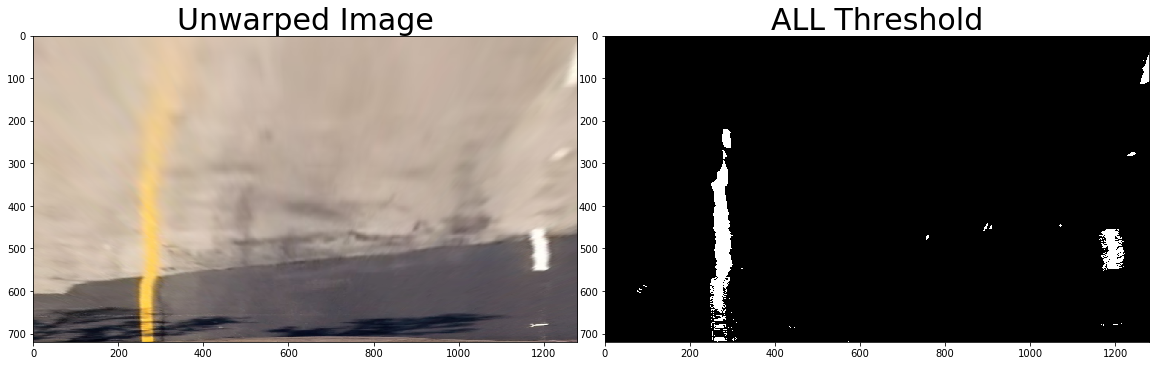

In [20]:
combined4 = np.zeros_like(exampleImg_sobelMag)
combined4[((combined2 == 1) | (combined3 == 1))] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp, cmap='gray')
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(combined4, cmap='gray')
ax2.set_title('ALL Threshold', fontsize=30)

#### Define Lane Finding Function

In [21]:
def find_lane(image):
    """
    :param image: origin image after warp
    :return combined: the image combine two lane find method result
    :return Minv: the inverse of the transform matrix
    """
    # set sobel kernel size
    sobel_kernel = 7
    with open('wide_dist_pickle.p', 'rb') as f:
        data = pickle.load(f)
    mtx = data['mtx']
    dist = data['dist']
    
    # Undistort
    img_undistort = distortion_image(image, mtx, dist)

    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort)
    
    # Sobel Absolute Threshold
    img_sobelAbs = abs_sobel_thresh(img_unwarp, sobel_kernel = sobel_kernel, thresh = (20, 120))

    # Sobel Gradient Magnitude Threshold
    img_sobelGraMag = mag_thresh(img_unwarp, sobel_kernel, thresh = (20, 120))

    # Sobel Direction Threshold
    img_sobelDir = dir_threshold(img_unwarp, sobel_kernel, thresh = (0.1, 0.6))

    # HLS S-channel Threshold
    img_SThresh = HLS_s_thresh(img_unwarp, thresh=(80, 255))
    
    # RGB R-Channel Threshold
    img_RThresh = RGB_r_thresh(img_unwarp, thresh=(240, 255))

    # Combine HLS S channel threshold and Sobel absolute
    combined1 = np.zeros_like(img_sobelAbs)
    combined1[((img_sobelAbs == 1) & (img_sobelGraMag == 1) & (img_sobelDir == 1))] = 1
    combined2 = np.zeros_like(img_sobelAbs)
    combined2[((img_SThresh == 1) & (img_RThresh == 1))] = 1
    combined = np.zeros_like(img_sobelAbs)
    combined[((combined1 == 1) | (combined2 == 1))] = 1
    return combined, Minv

Text(0.5, 1.0, 'Result')

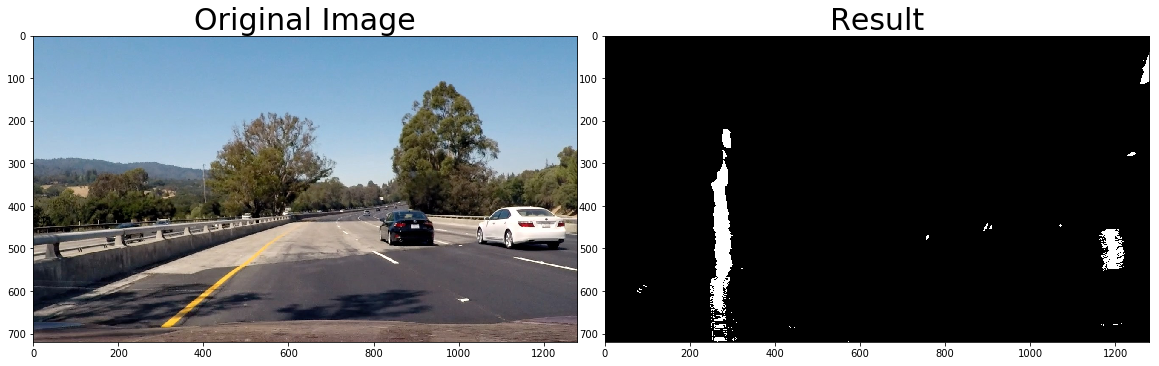

In [22]:
# exampleImg_rgb = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB) 
test, Minv = find_lane(exampleImg)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg, cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test, cmap='gray')
ax2.set_title('Result', fontsize=30)

#### Run The Lane Finding Function

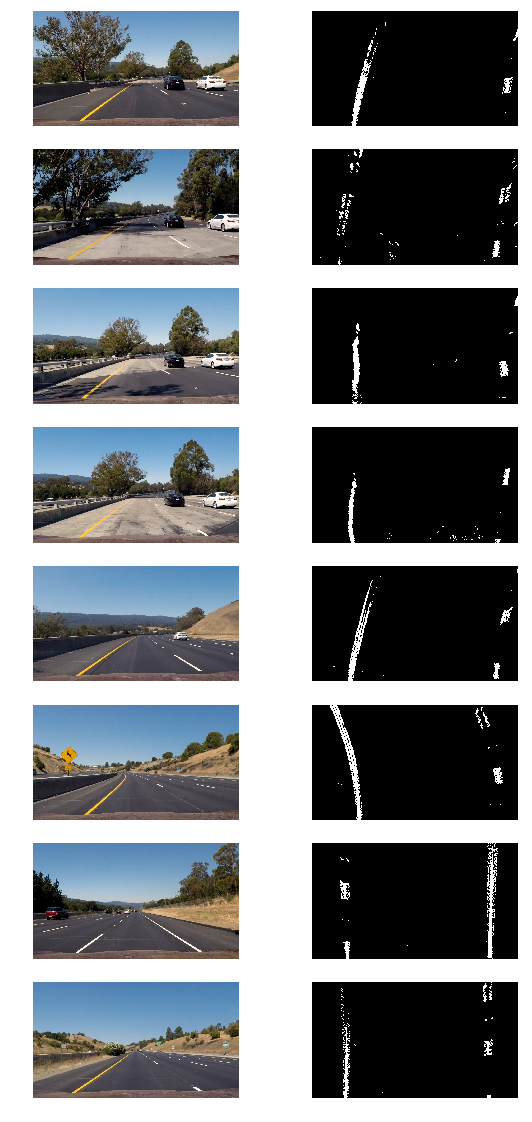

In [23]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = find_lane(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

### Sliding Window Polyfit

In [24]:
def slid_window(binary_warped):
    """
    :param binary_warped: the image for the slide window, it must be an binary image
    :return leftx: left line pixel positions
    :return lefty: left line pixel positions
    :return rightx: right line pixel positions
    :return righty: right line pixel positions
    :return out_img: output image to draw on and visualize the result
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on n windows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in n windows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

Text(0.5, 1.0, 'Out Image With Lane')

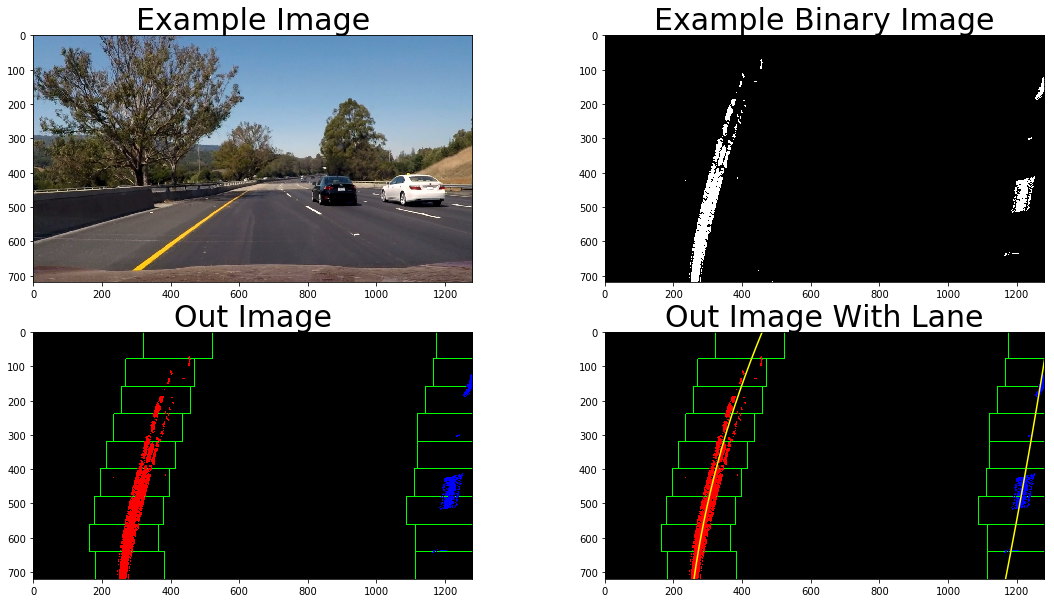

In [25]:
# Visualize the result on example image
exampleImg = cv2.imread('./test_images/test6.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = find_lane(exampleImg)

left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = slid_window(exampleImg_bin)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
# Colors in the left and right lane regions
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, axs = plt.subplots(2, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()
axs[0].imshow(exampleImg)
axs[0].set_title('Example Image', fontsize=30)
axs[1].imshow(exampleImg_bin, cmap='gray')
axs[1].set_title('Example Binary Image', fontsize=30)
axs[2].imshow(out_img, cmap='gray')
axs[2].set_title('Out Image', fontsize=30)
# Plots the left and right polynomials on the lane lines
axs[3].plot(left_fitx, ploty, color='yellow')
axs[3].plot(right_fitx, ploty, color='yellow')
axs[3].imshow(out_img, cmap='gray')
axs[3].set_title('Out Image With Lane', fontsize=30)

#### Fit polynomial to binary image based upon previous fit

In [26]:
def fit_poly_prev(binary_warped, left_fit_prev, right_fit_prev):
    """
    :param binary_warped: the image for polynomial, it must be an binary image
    :param left_fit_prev: left lane parameters of previous fit polynomial
    :param right_fit_prev: right lane parameters of previous fit polynomial
    :return left_fit_new: new left lane parameters of polynomail
    :return right_fit_new: new right lane parameters of polynomail
    :return left_lane_inds: new left lane indices
    :return right_lane_inds: new right lane indices
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

(720, 0)

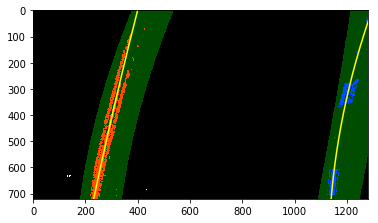

In [27]:
exampleImg2 = cv2.imread('./test_images/test3.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = find_lane(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = fit_poly_prev(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### Radius of Curvature and Distance from Lane Center Calculation

In [28]:
def measure_curvature_real(binary_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    """
    Calculates the curvature of polynomial functions in meters.
    :param bin_img: the binary image for calculation
    :param leftx: left line pixel positions
    :param lefty: left line pixel positions
    :param rightx: right line pixel positions
    :param righty: right line pixel positions
    :param left_fit: left lane parameters of polynomail
    :param right_fit: right lane parameters of polynomail
    :return left_curverad: left lane curvature in meters
    :return right_curverad: right lane curvature in meters
    :return center_dist: distance in meters which difference between car position and lane center position
    """
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 920  # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, binary_img.shape[0] - 1, binary_img.shape[0])
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)  x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    # Defint Car position
    car_position = binary_img.shape[1] / 2
    left_fit_x = left_fit[0] * binary_img.shape[0] ** 2 + left_fit[1] * binary_img.shape[0] + left_fit[2]
    right_fit_x = right_fit[0] * binary_img.shape[0] ** 2 + right_fit[1] * binary_img.shape[0] + right_fit[2]
    lane_center_position = (right_fit_x + left_fit_x) / 2
    center_dist = (car_position - lane_center_position) * xm_per_pix

    return left_curverad, right_curverad, center_dist

#### Calculate curvature radius and distance from center for example image

In [29]:
left_curverad, right_curverad, center_dist = measure_curvature_real(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', left_curverad, 'm,', right_curverad, 'm')
print('Distance from lane center for example:', center_dist, 'm')

Radius of curvature for example: 1145.371399823922 m, 8141.315065440155 m
Distance from lane center for example: -0.29636114918314105 m


#### Draw the Lane Back onto the Original Image

In [30]:
def draw_lane(img, binary_img, left_fit, right_fit, Minv):
    """
    :param img: origin image after warp
    :param binary_img: the binary image which find the lane lines
    :param left_fit: left lane parameters of polynomail
    :param right_fit: right lane parameters of polynomail
    :param Minv: the inverse of transform matrix
    :return result: the image which the lane lines draw on
    """
    new_img = np.copy(img)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_img.shape[0] - 1, binary_img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 255, 255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_img.shape[1], binary_img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

#### Draw the lane onto example image

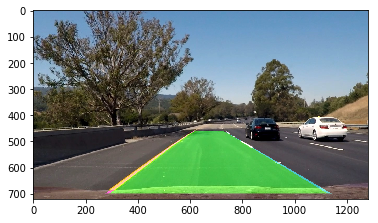

In [31]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)

#### Draw Curvature Radius and Distance from Center Data onto the Original Image

In [32]:
def description(img, left_curverad, right_curverad, center_dist):
    """
    :param img: origin image after warp
    :param left_curverad: left lane curvature in meters
    :param right_curverad: right lane curvature in meters
    :param center_dist: distance in meters which difference between car position and lane center position
    :return new_img: the image with description about curvature and distance difference between the car and lane cneter
    """
    new_img = np.copy(img)
    curvature = (left_curverad + right_curverad) / 2
    text = 'Radius of Curvature =  ' + ("%.3f" % curvature) + 'm'
    cv2.putText(new_img, text, (40, 70), cv2.FONT_HERSHEY_COMPLEX, 1.5, (200, 255, 155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Vehicle is ' + ("%.3f" % abs_center_dist) + 'm ' + str(direction) + ' of center'
    cv2.putText(new_img, text, (40, 120), cv2.FONT_HERSHEY_COMPLEX, 1.5, (200, 255, 155), 2, cv2.LINE_AA)
    return new_img

#### Write data onto example image

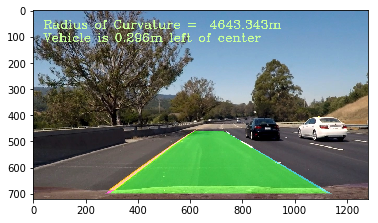

In [33]:
exampleImg_out2 = description(exampleImg_out1, left_curverad, right_curverad, center_dist)
plt.imshow(exampleImg_out2)

### Define a Line Class for Storing Data

In [65]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    # add fit to the line
    def add_fit(self, fit, inds):
        # if fit is found
        if fit is not None:
            if self.best_fit is not None:
                # if best fit existed, calculate the difference
                self.diffs = abs(fit-self.best_fit)
            # if the difference is too large andthere are no fits in the current_fit queue
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            # if not, change the self.detected to True and append the fit to the self.current_fit
            else:
                self.detected = True
                self.current_fit.append(fit)
                # keep the self.current_fit saved 8 fits and calculate the average value for the self.best_fit
                if len(self.current_fit) > 8:
                    self.current_fit = self.current_fit[len(self.current_fit)-8:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # if fit did not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out the oldest one
                self.current_fit = self.current_fit[1:]
            if len(self.current_fit) > 0:
                # if there are still any fits in the list, best_fit is the average of all
                self.best_fit = np.average(self.current_fit, axis=0)
                
        

### Define Complete Image Process

In [87]:
def process(img):
    new_img = np.copy(img)
    img_bin, Minv = find_lane(new_img)
    # if both left and right lines were detected last frame, use fit_poly_prev, otherwise use slid_window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, out_img = slid_window(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = fit_poly_prev(img_bin, l_line.best_fit, r_line.best_fit)
        
    # calculate the difference x value of left and right line, keep the difference in 920 pixels around 100 pixel
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(920 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = measure_curvature_real(img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        img_out = description(img_out1, rad_l, rad_r, d_center)
    else:
        img_out = new_img
    return img_out

finished


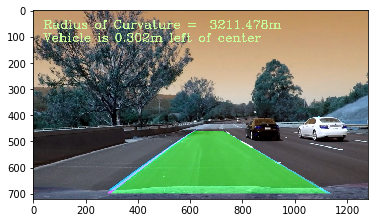

In [88]:
l_line = Line()
r_line = Line()
textImage = cv2.imread('./test_images/test6.jpg')
result = process(textImage)
plt.imshow(result)
print("finished")

### Process Project Video

In [71]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(20,28)
processed_video = video_input1.fl_image(process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:26<00:00,  5.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 20min 44s, sys: 33 s, total: 21min 17s
Wall time: 3min 27s


### Process Challenge Video

In [89]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(0,3)
# video_input2.save_frame("challenge01.jpg", t= 2.5)
processed_video = video_input2.fl_image(process)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:17<00:00,  6.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 7min 50s, sys: 11.4 s, total: 8min 1s
Wall time: 1min 18s


### Process Harder Challenge Video

In [90]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
processed_video = video_input3.fl_image(process)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:31<00:00,  4.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 21min 13s, sys: 31.5 s, total: 21min 45s
Wall time: 3min 32s
